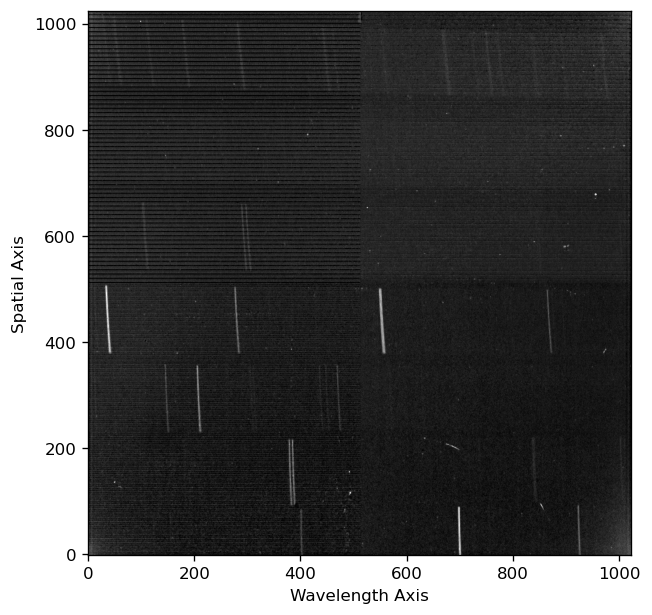

In [3]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from lmfit import Model
from lmfit import minimize, Parameters

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 65 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
#plt.figure(figsize=(12,6))
#plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.xlabel('Wavelength Axis')
#plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
#plt.colorbar(orientation='horizontal', pad=0.1)


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load skylines
skylines = fits.open(filepath + 'skyandarc2.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(12,6))
plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

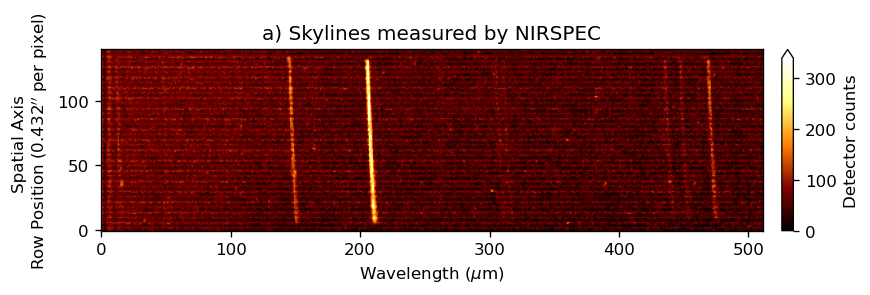

In [28]:
a = np.delete(skylines, np.s_[512:1024], 1)
b = np.delete(a, np.s_[:225], 0)
c = np.delete(b, np.s_[140:], 0)
#pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
plt.figure(figsize=(10,2))
plt.imshow(c, cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')
plt.savefig('poster/skyline_img', bbox_inches='tight')

(0.0, 10.0)

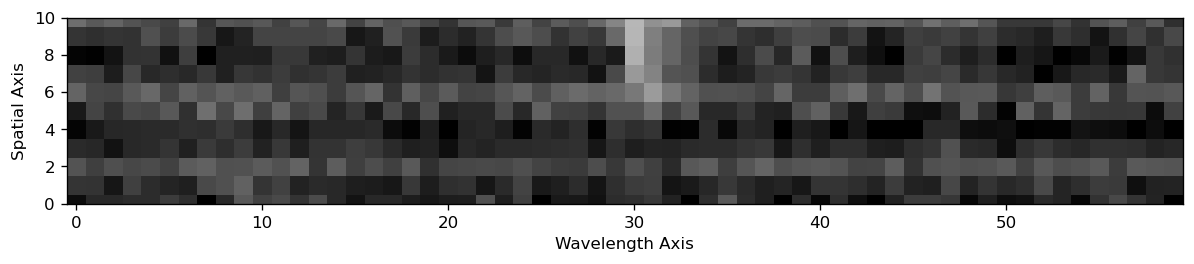

In [18]:
d = np.delete(c, np.s_[180:], 1)
e = np.delete(d, np.s_[:120], 1)
pixel = np.linspace(0, np.size(e, 1), np.size(e, 1))
plt.figure(figsize=(12,6))
plt.imshow(e, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.ylim(0,10)

In [60]:
d = np.delete(c, np.s_[180:], 1)
e = np.delete(d, np.s_[:120], 1)
pixel = np.linspace(0, np.size(e, 1), np.size(e, 1))

upper_skyline = 135
lower_skyline = 5

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=26)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 45 and i < 105:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=28)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 5 and i < 45:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=30)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
        
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1 + 120

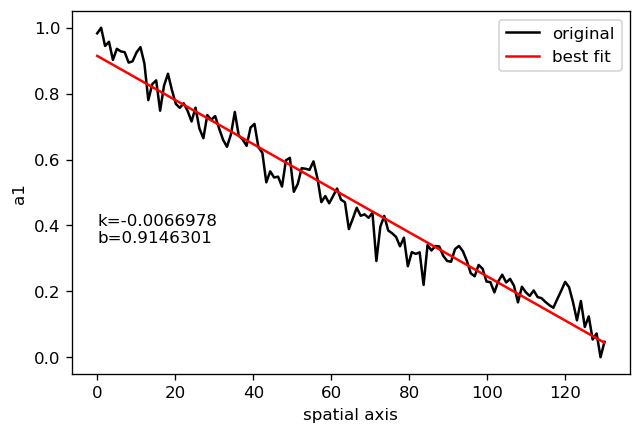

In [61]:
sky1_spat = np.linspace(0, len(sky1_a1), len(sky1_a1))

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=1)

out = minimize(residual, params, args=(sky1_spat, normalize(sky1_a1)))

sky1_k = out.params['k'].value
sky1_b = out.params['b'].value


plt.figure()
plt.plot(sky1_spat, normalize(sky1_a1),'k', label = 'original')
plt.plot(sky1_spat, sky1_k*sky1_spat + sky1_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.annotate('k='+str(round(out.params['k'].value, 7)), xy=(0, 0.4))
plt.annotate('b='+str(round(out.params['b'].value, 7)), xy=(0, 0.35))
plt.legend()

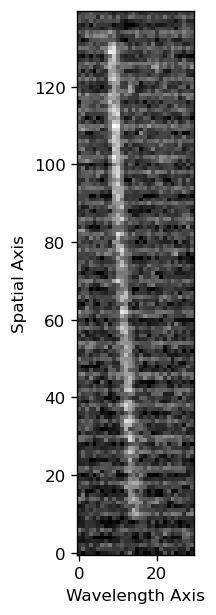

In [62]:
f = np.delete(c, np.s_[490:], 1)
g = np.delete(f, np.s_[:460], 1)
pixel = np.linspace(0, np.size(g, 1), np.size(g, 1))
plt.figure(figsize=(12,6))
plt.imshow(g, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.ylim(0,20)

In [79]:
f = np.delete(c, np.s_[490:], 1)
g = np.delete(f, np.s_[:460], 1)
pixel = np.linspace(0, np.size(g, 1), np.size(g, 1))

upper_skyline = 135
lower_skyline = 10

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=9)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 75 and i < 105:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=11)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
    if i >= 45 and i < 75:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=12)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 10 and i < 45:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=14)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1 + 460

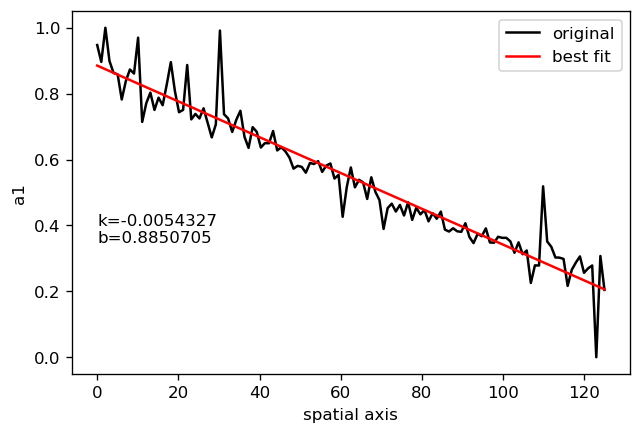

In [80]:
sky3_spat = np.linspace(0, len(sky3_a1), len(sky3_a1))

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=1)

out = minimize(residual, params, args=(sky3_spat, normalize(sky3_a1)))

sky3_k = out.params['k'].value
sky3_b = out.params['b'].value


plt.figure()
plt.plot(sky3_spat, normalize(sky3_a1),'k', label = 'original')
plt.plot(sky3_spat, sky3_k*sky3_spat + sky3_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.annotate('k='+str(round(out.params['k'].value, 7)), xy=(0, 0.4))
plt.annotate('b='+str(round(out.params['b'].value, 7)), xy=(0, 0.35))
plt.legend()

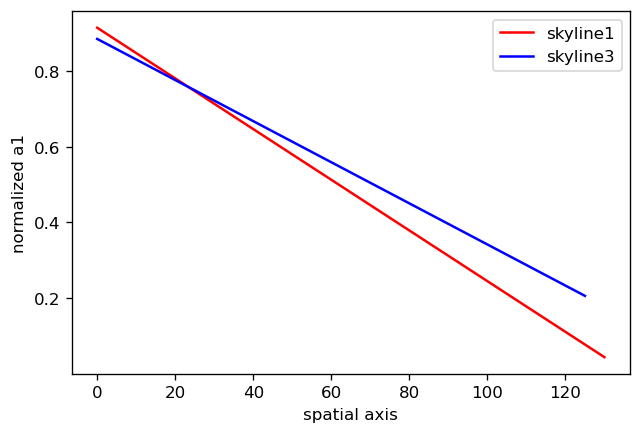

In [81]:
plt.figure()
plt.plot(sky1_spat, sky1_k*sky1_spat + sky1_b, 'r', label = 'skyline1')
plt.plot(sky3_spat, sky3_k*sky3_spat + sky3_b, 'b', label = 'skyline3')
plt.xlabel('spatial axis')
plt.ylabel('normalized a1')
plt.legend()